# Example - Marketing to frequent fliers

### Introduction

This example illustrates the *k*-**means** method for **clustering**, as provided by the Python package scikit-learn, as one of basic **unsupervised learning** methods. The example uses data from the file `fliers.csv`, which contains information on 3,999 passengers who belong to the EastWest's **frequent flier program**. The information covers the passenger's mileage history and the different ways he/she accrued or spent miles in the last year. 

This is a standard case of **customer segmentation**. The goal is to identify **clusters of passengers** that have similar characteristics for the purpose of targeting different segments for different types of mileage offers. Key issues are their flying patterns, earning and use of frequent flier rewards, and use of the airline credit card.

### The data set

The variables included in the data set are:

* `id`, a unique customer ID.

* `balance`, the number of miles eligible for award travel.

* `qual_miles`, the number of miles counted as qualifying for Topflight status.

* `cc1_miles`, the number of miles earned with frequent flier credit card in the past 12 months, coded as 1 (under 5,000), 2 (5,000-10,000), 3 (10,001-25,000), 4 (25,001-50,000).

* `cc2_miles`, the number of miles earned with Rewards credit card in the past 12 months, coded as above.

* `cc3_miles`, the number of miles earned with Small Business credit card in the past 12 months, coded as above.

* `bonus_miles`, the number of miles earned from non-flight bonus transactions in the past 12 months.

* `bonus_trans`, the number of non-flight bonus transactions in the past 12 months.

* `flight_miles_12mo`, the number of miles flight miles in the past 12 months.

* `flight_trans_12mo`, the number of flight transactions in the past 12 months.

* `days_since_enroll`, the number of days since the customer was enrolled.

* `award`, a dummy for having an award.

Source: G Shmueli and PC Bruce (2016), based upon a real business case and real data. The company name has been changed.

### Importing the data

I import the data, from a **remote file**, to a **structured NumPy array**, as usual:

In [1]:
import numpy as np
path = 'https://raw.githubusercontent.com/cinnData/MLearning/main/12.%20Clustering/'
fname = path + 'fliers.csv'
data = np.genfromtxt(fname, delimiter=',', names=True, dtype=None, encoding='utf-8')

I check the shape of the array:

In [2]:
data.shape

(3999,)

The contents of the first rows:

In [3]:
data[:10]

array([( 1,  28143, 0, 1, 1, 1,   174,  1,    0,  0, 7000, 0),
       ( 2,  19244, 0, 1, 1, 1,   215,  2,    0,  0, 6968, 0),
       ( 3,  41354, 0, 1, 1, 1,  4123,  4,    0,  0, 7034, 0),
       ( 4,  14776, 0, 1, 1, 1,   500,  1,    0,  0, 6952, 0),
       ( 5,  97752, 0, 4, 1, 1, 43300, 26, 2077,  4, 6935, 1),
       ( 6,  16420, 0, 1, 1, 1,     0,  0,    0,  0, 6942, 0),
       ( 7,  84914, 0, 3, 1, 1, 27482, 25,    0,  0, 6994, 0),
       ( 8,  20856, 0, 1, 1, 1,  5250,  4,  250,  1, 6938, 1),
       ( 9, 443003, 0, 3, 2, 1,  1753, 43, 3850, 12, 6948, 1),
       (10, 104860, 0, 3, 1, 1, 28426, 28, 1150,  3, 6931, 1)],
      dtype=[('id', '<i4'), ('balance', '<i4'), ('qual_miles', '<i4'), ('cc1_miles', '<i4'), ('cc2_miles', '<i4'), ('cc3_miles', '<i4'), ('bonus_miles', '<i4'), ('bonus_trans', '<i4'), ('flight_miles_12mo', '<i4'), ('flight_trans_12mo', '<i4'), ('days_since_enroll', '<i4'), ('award', '<i4')])

### Exploratory analysis

At first glance, the data show a mix of scales, suggesting that some of the clustering features can have a much stronger influence on the clusters than others. The four figures in the panel below illustrate this. Moreover, three of these features also have skewed distributions, which help to create small clusters.

In [5]:
from matplotlib import pyplot as plt

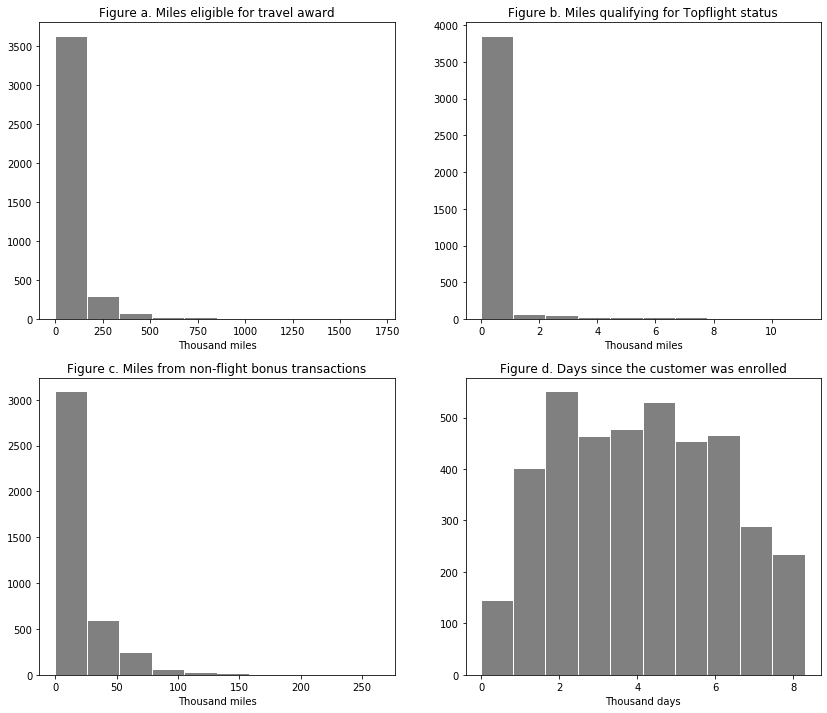

In [16]:
plt.figure(figsize = (14,12))
plt.subplot(2, 2, 1)
plt.title('Figure a. Miles eligible for travel award')
plt.hist(data['balance']/1000, color='gray', rwidth=0.97)
plt.xlabel('Thousand miles')
plt.subplot(2, 2, 2)
plt.title('Figure b. Miles qualifying for Topflight status')
plt.hist(data['qual_miles']/1000, color='gray', rwidth=0.97)
plt.xlabel('Thousand miles')
plt.subplot(2, 2, 3)
plt.title('Figure c. Miles from non-flight bonus transactions')
plt.hist(data['bonus_miles']/1000, color='gray', rwidth=0.97)
plt.xlabel('Thousand miles')
plt.subplot(2, 2, 4)
plt.title('Figure d. Days since the customer was enrolled')
plt.hist(data['days_since_enroll']/1000, color='gray', rwidth=0.97)
plt.xlabel('Thousand days');

The distributions of the features related to the credit cards are, in two cases, very unbalanced.

In [17]:
np.unique(data['cc1_miles'], return_counts=True)

(array([1, 2, 3, 4, 5]), array([2289,  284,  613,  525,  288], dtype=int64))

In [18]:
np.unique(data['cc2_miles'], return_counts=True)

(array([1, 2, 3]), array([3956,   28,   15], dtype=int64))

In [19]:
np.unique(data['cc3_miles'], return_counts=True)

(array([1, 2, 3, 4, 5]), array([3981,    3,    4,    6,    5], dtype=int64))

In spite of all these problems, data of this type are frequently used in customer segmentation. So, let us see how they work.

### Feature matrix

This is unsupervised learning, so there is no target vector. I create a **feature matrix** from the **structured array** `data`, leaving aside the column `id`:

In [20]:
from numpy.lib.recfunctions import structured_to_unstructured
X = structured_to_unstructured(data)[:, 1:]

### 4-cluster analysis, first round

In scikit-learn to protocol to work with unsupervised learning estimators is similar to that of the supervised learning examples that we have seen in other examples. I import the estimator class `KMeans`:

In [21]:
from sklearn.cluster import KMeans

Then I instantiate an estimator, which I call `clus`, setting the number of clusters at 4 and `random_state=0`for repeatability:

In [22]:
clus = KMeans(n_clusters=4, random_state=0)

Now I fit the estimator to the feature matrix `X`. Note that, in unsupervised learning, it is `mod.fit(X)`, instead of `mod.fit(X, y)`.

In [23]:
clus.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

As a result of fitting `clus`, we can extract two interesting attributes, `labels_` and `cluster_centers_`:

In [24]:
labels = clus.labels_
centers = clus.cluster_centers_

Let us look at the **labels** first. With 4 clusters, they are 0, 1, 2 and 3. They come as a 1d array in which every term indicates the cluster to which the corresponding customer has been assigned. In customer segmentation, you should always check that all the segments have a minimum size, compared to the number of customers, which is here 3,999. Unfortunately, this is not the case here:

In [25]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([2808,  185,  980,   26], dtype=int64))

The **centers** are four rows of 11 terms, one for every segment. They can be taken as "ideal customers", representing the corresponding clusters. The features of these ideal customers are calculated as the average of the feature values in the their segments. They come as a 2d array, with one center in each row:

In [26]:
centers.shape

(4, 11)

To examine on the screen the centers having them as a (4,11)-array is a bit challenging for our eyes, so we are going to take advantage of the package Pandas to display them as a friendly table. We add column names and a last column with the cluster size.

In [62]:
import pandas as pd
pdcenters = pd.DataFrame(centers).round(1)
pdcenters.columns = data.dtype.names[1:]
pdcenters['size'] = np.unique(labels, return_counts=True)[1]
pdcenters

,balance,qual_miles,cc1_miles,cc2_miles,cc3_miles,bonus_miles,bonus_trans,flight_miles_12mo,flight_trans_12mo,days_since_enroll,award,size
0,31007.0,101.6,1.7,1.0,1.0,10109.1,9.3,290.2,0.9,3785.6,0.3,2808
1,323009.8,337.2,3.1,1.0,1.0,43644.1,18.6,1283.3,3.9,5532.6,0.6,185
2,128368.9,219.9,2.9,1.0,1.0,31266.5,16.5,755.5,2.2,4745.5,0.4,980
3,842320.2,512.7,3.3,1.0,1.1,57797.2,22.7,1845.9,7.0,6463.0,0.8,26


It is plainly seen that the segments only reflect who flies more. This is not unexpected, given the features that we are using in the analysis.

### Normalization

The **max-min normalization** is a popular normalization algorithm, widely applied with neural network models and with **distance-based clustering algorithms**. In scikit-learn, it can be extracted from the class `MinMaxScaler`, in the subpackage `preprocessing`. As usual, I import the class:

In [32]:
from sklearn.preprocessing import MinMaxScaler

Then, I instatantiate a transformer from this class:

In [33]:
scaler = MinMaxScaler()

Finally, I apply the methods `fit`  and `transform` to get the **normalized feature matrix**:

In [35]:
scaler.fit(X)
Z = scaler.transform(X)

### 4-cluster analysis, second round

I redo the analysis, replacing `X` by `Z`.

In [68]:
clus.fit(Z)
labels = clus.labels_
centers = clus.cluster_centers_
pdcenters = pd.DataFrame(centers)
pdcenters.columns = data.dtype.names[1:]
pdcenters['size'] = np.unique(labels, return_counts=True)[1]
pdcenters

,balance,qual_miles,cc1_miles,cc2_miles,cc3_miles,bonus_miles,bonus_trans,flight_miles_12mo,flight_trans_12mo,days_since_enroll,award,size
0,0.023901,0.008284,0.023195,0.008962,0.001054,0.012648,0.075450,0.007353,0.012433,0.436112,3.275158e-15,1897
1,0.048995,0.026054,0.039004,0.016345,0.002229,0.033564,0.121825,0.033427,0.059407,0.522892,1.000000e+00,673
2,0.063535,0.017791,0.728960,0.000619,0.006498,0.172970,0.234904,0.023160,0.040421,0.586139,1.000000e+00,808
3,0.069234,0.006558,0.644122,0.000805,0.005636,0.118637,0.200595,0.007313,0.011941,0.534640,-3.885781e-16,621


### Homework

1. Use `random_state=1` and `random_state=2` when clustering of the normalized data set and compare the clusters obtained with those presented in the example.

2. Use `n_clusters=3` and `n_clusters=5` when clustering of the normalized data set and compare the clusters obtained with those presented in the example.